<a href="https://colab.research.google.com/github/shyamsparrow/Jan-G4---NLP-Chatbot/blob/Models/Capstone_NLP_Chatbot_Jan_A_G4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - NLP Chatbot

### DOMAIN: 
Industrial safety. NLP based Chatbot.

### CONTEXT:
The database comes from one of the biggest industry in Brazil and in the world. It is an urgent need for industries/companies around the globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.

### DATA DESCRIPTION:
This The database is basically records of accidents from 12 different plants in 03 different countries which every line in the data is an occurrence of an accident.

### Columns description:
* Data: timestamp or time/date information
* Countries: which country the accident occurred (anonymised)
* Local: the city where the manufacturing plant is located (anonymised)
* Industry sector: which sector the plant belongs to
* Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
* Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have   been (due to other factors involved in the accident)
* Gender: if the person is male of female
* Employee or Third Party: if the injured person is an employee or a third party
* Critical Risk: some description of the risk involved in the accident
* Description: Detailed description of how the accident happened.

Link to download the dataset: https://drive.google.com/file/d/1_GmrRP1S2OIa02KlfOBNkYa8uxazGbfE/view?usp=sharing,
Original dataset link: https://www.kaggle.com/ihmstefanini/industrial-safety-and-health-analytics-database

### PROJECT OBJECTIVE:
Design a ML/DL based chatbot utility which can help the professionals to highlight the safety risk as per the incident description.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Replace the folder path with your drive folder path and clone the githb repo

In [2]:
%cd /content/drive/MyDrive/AIML/Capstone

/content/drive/MyDrive/AIML/Capstone


Run the below code for clone the repo in our Googele drive for first time

In [3]:
! git clone https://github.com/shyamsparrow/Jan-G4---NLP-Chatbot.git

fatal: destination path 'Jan-G4---NLP-Chatbot' already exists and is not an empty directory.


Change the Current folder into Github repo main folder, all the functions we are calling has to be in this repo.

In [4]:
%cd /content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot

/content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot


In [6]:
!git checkout Models

M	data_augmentation.csv
M	industry_df_with_stopwords.csv
Already on 'Models'
Your branch is up to date with 'origin/Models'.


In [48]:
!git pull

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/shyamsparrow/Jan-G4---NLP-Chatbot
   9f937aa..4183271  Models     -> origin/Models
Updating 9f937aa..4183271
Fast-forward
 ...Transformer_Capstone_NLP_Chatbot_Jan_A_G4.ipynb | 682 +++++++++++++++++----
 1 file changed, 578 insertions(+), 104 deletions(-)


Run this code to update the changes in repo to our drive

In [5]:
import warnings
warnings.filterwarnings('ignore')

import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

## LSTM:

In [27]:
industry_df = pd.read_csv("industry_df_with_stopwords.csv")

In [28]:
from nltk.tokenize import word_tokenize
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import pickle

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, LSTM,  Embedding, Dropout, Bidirectional, GlobalMaxPool1D

from keras.utils import np_utils
from keras.layers.merge import Concatenate
#from keras.utils import plot_model

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Keras pre-processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [29]:
# Select input and output features

X_text = industry_df['Description_preprocessed']
y_text = industry_df['Potential_Accident_Level']

In [30]:
# Encode labels in column 'Potential Accident Level'and Convert into one-hot encoded vectors:
le = LabelEncoder()
le.fit(y_text)
y_text = le.transform(y_text)
y_text = np_utils.to_categorical(y_text)

In [31]:
# Divide our data into testing and training sets:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text, y_text, test_size = 0.20, random_state = 1)

print('X_text_train shape : ({0})'.format(X_text_train.shape))
print('y_text_train shape : ({0},)'.format(y_text_train.shape))
print('X_text_test shape : ({0})'.format(X_text_test.shape))
print('y_text_test shape : ({0},)'.format(y_text_test.shape))

X_text_train shape : ((328,))
y_text_train shape : ((328, 5),)
X_text_test shape : ((83,))
y_text_test shape : ((83, 5),)


In [ ]:
industry_df['sentence_length'].value_counts()

1    178
2    130
3     60
4     23
5     12
6      5
8      2
7      1
Name: sentence_length, dtype: int64

In [24]:
# The first step in word embeddings is to convert the words into thier corresponding numeric indexes.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_text_train)

X_text_train = tokenizer.texts_to_sequences(X_text_train)
X_text_test = tokenizer.texts_to_sequences(X_text_test)

In [25]:
industry_df['nb_words'] = industry_df['Description_preprocessed'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(industry_df['nb_words'].min()))
print('Maximum number of words: {}'.format(industry_df['nb_words'].max()))

Minimum number of words: 16
Maximum number of words: 183


In [26]:
vocab_size = len(tokenizer.word_index) + 1
print("vocab_size:", vocab_size)

maxlen = 200

X_text_train = pad_sequences(X_text_train, padding='post', maxlen=maxlen)
X_text_test = pad_sequences(X_text_test, padding='post', maxlen=maxlen)

vocab_size: 3446


In [27]:
X_text_train.shape

(656, 185)

In [ ]:
print('Indexing word vectors.')

embeddings_dictionary = {}
f = open('glove.6B.200d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dictionary[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_dictionary))

In [ ]:
pickle.dump(embeddings_dictionary, open('/content/drive/MyDrive/AIML/Capstone/embeddings.pickle', 'wb'))

In [29]:
infile = open('/content/drive/MyDrive/AIML/Capstone/embeddings.pickle','rb')
embeddings_dictionary = pickle.load(infile)

In [ ]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [ ]:
vocab = build_vocab(pd.Series(X_aug_train))

In [ ]:
len(vocab)

3449

In [ ]:
import operator 

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [ ]:
oov_glove = check_coverage(vocab, embeddings_dictionary)

Found embeddings for 93.97% of vocab
Found embeddings for  98.93% of all text


In [30]:
embedding_size = 200

embedding_matrix = np.zeros((vocab_size, embedding_size))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
embedding_matrix.shape

(3446, 200)

In [ ]:
base_model = Sequential()
base_model.add(Embedding(vocab_size, output_dim=embedding_size, weights=[embedding_matrix], input_length=185, trainable=False))
#LSTM 
base_model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
base_model.add(Dense(5, activation='softmax'))
base_model.compile(optimizer=optimizers.Adam(lr = 0.001), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 185, 200)          689200    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              336896    
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                                 
Total params: 1,027,381
Trainable params: 338,181
Non-trainable params: 689,200
_________________________________________________________________


In [ ]:
X_text_train.shape,np.array(y_aug_train).shape,X_text_test.shape, y_text_test.shape

((656, 185), (656, 5), (83, 185), (83, 5))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.001)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=3, min_delta=1E-4)

# fit the keras model on the dataset
base_model_history = base_model.fit(X_text_train, np.array(y_aug_train), epochs=10, batch_size=8, verbose=1, validation_data=(X_text_test, y_text_test), callbacks=[rlrp])

Epoch 1/10
82/82 [==============================] - 60s 644ms/step - loss: 0.4887 - acc: 0.3110 - val_loss: 0.4534 - val_acc: 0.3614 - lr: 0.0010
Epoch 2/10
82/82 [==============================] - 47s 571ms/step - loss: 0.4653 - acc: 0.3460 - val_loss: 0.4468 - val_acc: 0.3253 - lr: 0.0010
Epoch 3/10
82/82 [==============================] - 48s 582ms/step - loss: 0.4509 - acc: 0.3659 - val_loss: 0.4288 - val_acc: 0.3735 - lr: 0.0010
Epoch 4/10
82/82 [==============================] - 47s 576ms/step - loss: 0.4337 - acc: 0.4253 - val_loss: 0.4445 - val_acc: 0.3855 - lr: 0.0010
Epoch 5/10
82/82 [==============================] - 48s 589ms/step - loss: 0.4095 - acc: 0.4726 - val_loss: 0.4546 - val_acc: 0.4217 - lr: 0.0010
Epoch 6/10
82/82 [==============================] - 47s 575ms/step - loss: 0.3849 - acc: 0.4939 - val_loss: 0.4351 - val_acc: 0.4217 - lr: 0.0010
Epoch 7/10
82/82 [==============================] - 47s 577ms/step - loss: 0.3541 - acc: 0.5610 - val_loss: 0.4348 - val_acc

In [ ]:
_, train_accuracy = base_model.evaluate(X_text_train, np.array(y_aug_train), batch_size=8, verbose=0)
_, test_accuracy = base_model.evaluate(X_text_test, y_text_test, batch_size=8, verbose=0)

print('Train accuracy: %.2f' % (train_accuracy*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

Train accuracy: 59.15
Test accuracy: 43.37


In [ ]:
y_pred = base_model.predict(X_text_test, verbose=0) # Multiclass
y_pred_index = np.argmax(y_pred,axis=1)
y_original = np.argmax(y_text_test, axis =1)

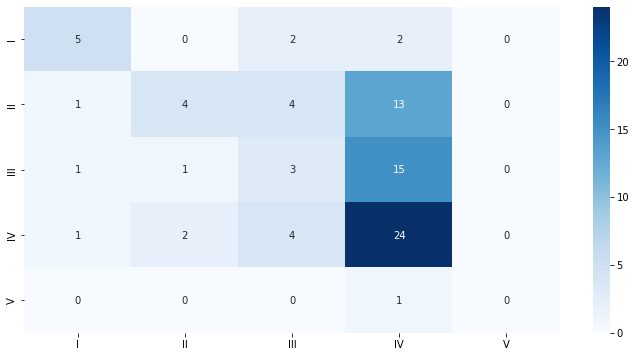

In [ ]:
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label);

In [ ]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.62      0.56      0.59         9
           1       0.57      0.18      0.28        22
           2       0.23      0.15      0.18        20
           3       0.44      0.77      0.56        31
           4       0.00      0.00      0.00         1

    accuracy                           0.43        83
   macro avg       0.37      0.33      0.32        83
weighted avg       0.44      0.43      0.39        83



In [ ]:

# Build a LSTM Neural Network
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], trainable=False)(deep_inputs)

LSTM_Layer_1 = Bidirectional(LSTM(128, return_sequences = True))(embedding_layer)
max_pool_layer_1 = GlobalMaxPool1D()(LSTM_Layer_1)
drop_out_layer_1 = Dropout(0.5, input_shape = (256,))(max_pool_layer_1)
dense_layer_1 = Dense(128, activation = 'relu')(drop_out_layer_1)
drop_out_layer_2 = Dropout(0.5, input_shape = (128,))(dense_layer_1)
dense_layer_2 = Dense(64, activation = 'relu')(drop_out_layer_2)
drop_out_layer_3 = Dropout(0.5, input_shape = (64,))(dense_layer_2)

dense_layer_3 = Dense(32, activation = 'relu')(drop_out_layer_3)
drop_out_layer_4 = Dropout(0.5, input_shape = (32,))(dense_layer_3)

dense_layer_4 = Dense(10, activation = 'relu')(drop_out_layer_4)
drop_out_layer_5 = Dropout(0.5, input_shape = (10,))(dense_layer_4)

dense_layer_5 = Dense(5, activation='softmax')(drop_out_layer_5)

lstm_model = Model(inputs=deep_inputs, outputs=dense_layer_5)

opt = optimizers.Adam(lr=0.001)
#opt = optimizers.SGD(lr=0.0001, momentum=0.9)
lstm_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

In [ ]:
print(lstm_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 185)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 185, 200)          689200    
                                                                 
 bidirectional_1 (Bidirectio  (None, 185, 256)         336896    
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896 

In [ ]:
class Metrics(tf.keras.callbacks.Callback):

    def __init__(self, validation_data=()):
        super().__init__()
        self.validation_data = validation_data

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        xVal, yVal = self.validation_data
        val_predict_classes = (np.asarray(self.model.predict(xVal))).round() # Multilabel
        
        
        val_targ = yVal

        _val_f1 = f1_score(val_targ, val_predict_classes, average='micro')
        _val_recall = recall_score(val_targ, val_predict_classes, average='micro')
        _val_precision = precision_score(val_targ, val_predict_classes, average='micro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        #print("— train_f1: %f — train_precision: %f — train_recall %f" % (_val_f1, _val_precision, _val_recall))
        return

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=1E-2)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3, min_delta=1E-2)

metrics = Metrics(validation_data=(X_text_train, np.array(y_aug_train)))

# fit the keras model on the dataset X_text_train, np.array(y_aug_train)
training_history = lstm_model.fit(X_text_train, np.array(y_aug_train), epochs=20, batch_size=8, verbose=1, validation_data=(X_text_test, y_text_test), callbacks=[rlrp,metrics])

Epoch 1/20
82/82 [==============================] - 22s 269ms/step - loss: 1.6013 - acc: 0.2530 - val_loss: 1.5266 - val_acc: 0.3735 - lr: 0.0010
Epoch 2/20
82/82 [==============================] - 21s 256ms/step - loss: 1.5735 - acc: 0.2591 - val_loss: 1.5076 - val_acc: 0.3735 - lr: 0.0010
Epoch 3/20
82/82 [==============================] - 21s 254ms/step - loss: 1.5438 - acc: 0.2912 - val_loss: 1.4706 - val_acc: 0.3735 - lr: 0.0010
Epoch 4/20
82/82 [==============================] - 20s 249ms/step - loss: 1.5364 - acc: 0.3034 - val_loss: 1.4761 - val_acc: 0.3735 - lr: 0.0010
Epoch 5/20
82/82 [==============================] - 21s 259ms/step - loss: 1.5400 - acc: 0.3247 - val_loss: 1.4601 - val_acc: 0.3735 - lr: 0.0010
Epoch 6/20
82/82 [==============================] - 20s 250ms/step - loss: 1.5225 - acc: 0.3095 - val_loss: 1.4601 - val_acc: 0.3735 - lr: 0.0010
Epoch 7/20
82/82 [==============================] - 21s 254ms/step - loss: 1.5251 - acc: 0.3308 - val_loss: 1.4492 - val_acc

In [ ]:
with open('/content/drive/MyDrive/AIML/Capstone/parameters.pickle', "wb") as f:
  pickle.dump((le, tokenizer), f)

In [ ]:
lstm_model_json = lstm_model.to_json()
with open("LSTM_aug_model.json", "w") as json_file:
    json_file.write(lstm_model_json)
    
# serialize weights to HDF5
lstm_model.save_weights("LSTM_aug_model_weights.h5")
print("Saved model weights to disk")

# Save the model in h5 format 
lstm_model.save("LSTM_aug_model.h5")
print("Saved model to disk")

Saved model weights to disk
Saved model to disk


In [ ]:
# evaluate the keras model
_, train_accuracy = lstm_model.evaluate(X_text_train, y_text_train, batch_size=8, verbose=0)
_, test_accuracy = lstm_model.evaluate(X_text_test, y_text_test, batch_size=8, verbose=0)

print('Train accuracy: %.2f' % (train_accuracy*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

Train accuracy: 33.33
Test accuracy: 34.55


In [ ]:
  with open('/content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot/Utilities/result_df.csv', "rb") as f:
      result_df = pickle.load(f)

In [ ]:
y_pred = lstm_model.predict(X_text_test, verbose=0) # Multiclass
y_pred_index = np.argmax(y_pred,axis=1)
y_original = np.argmax(y_text_test, axis =1)

In [ ]:
_,tr_accuracy = lstm_model.evaluate(X_text_train,y_text_train) 
_,te_accuracy = lstm_model.evaluate(X_text_test,y_text_test) 

F1_sre= f1_score(y_original,y_pred_index, average='micro')
tr_accuracy,te_accuracy,F1_sre

6/6 [==============================] - 1s 216ms/step - loss: 1.4804 - acc: 0.3455


(0.3333333432674408, 0.34545454382896423, 0.34545454545454546)

In [ ]:
result_df.loc[len(result_df.index)] = ['LSTM_Aug_Model', tr_accuracy, te_accuracy,F1_sre] 
result_df

,Model,Train_accuracy,Test_accuracy,F1_score
0,LogReg,0.890244,0.890244,0.373494
1,Naive Bayes,1.000000,1.000000,0.421687
2,KNN,0.591463,0.591463,0.361446
3,SVM,0.990854,0.990854,0.361446
4,Decision Tree,0.512195,0.512195,0.313253
5,RandomForest,0.612805,0.612805,0.373494
6,Bagging,1.000000,1.000000,0.373494
7,AdaBoost,0.393293,0.393293,0.349398
8,Gradient Boost,0.920732,0.920732,0.325301
9,XGBoost,0.951220,0.951220,0.313253


In [ ]:
with open('/content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot/result_df.csv', "wb") as f:
  pickle.dump((result_df), f)

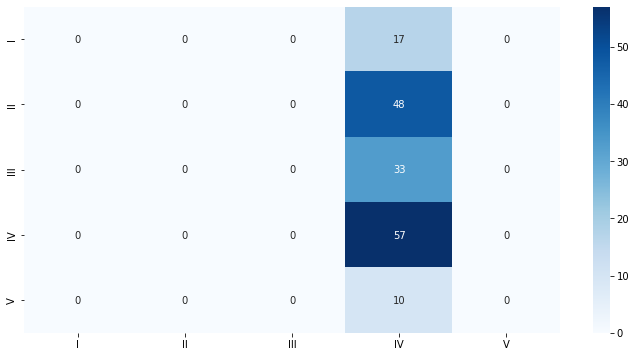

In [ ]:
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label);

In [ ]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        33
           3       0.35      1.00      0.51        57
           4       0.00      0.00      0.00        10

    accuracy                           0.35       165
   macro avg       0.07      0.20      0.10       165
weighted avg       0.12      0.35      0.18       165



Text(0.5, 1.0, 'Training and validation loss')

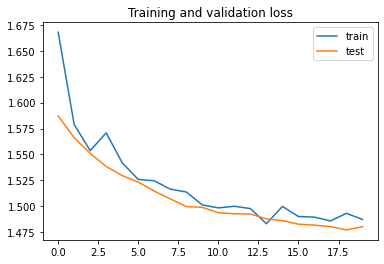

In [ ]:
epochs = range(len(training_history.history['loss'])) # Get number of epochs

# plot loss learning curves
plt.plot(epochs, training_history.history['loss'], label = 'train')
plt.plot(epochs, training_history.history['val_loss'], label = 'test')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

Text(0.5, 1.0, 'Training and validation accuracy')

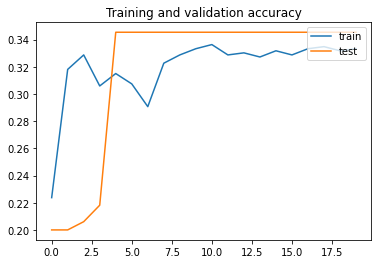

In [ ]:
# plot accuracy learning curves
plt.plot(epochs, training_history.history['acc'], label = 'train')
plt.plot(epochs, training_history.history['val_acc'], label = 'test')
plt.legend(loc = 'upper right')
plt.title ('Training and validation accuracy')

In [ ]:
%cd /content/drive/MyDrive/AIML/Capstone

/content/drive/MyDrive/AIML/Capstone


In [ ]:
from keras.models import load_model
model = load_model('finalized_LSTM_model.h5')

In [ ]:
def model_prediction(usr_txt):
  with open('/content/drive/MyDrive/AIML/Capstone/parameters.pickle', "rb") as f:
      lab_en, tokenizer_data = pickle.load(f)
  from NLP_text_preprocess import PreProcessing
  pp = PreProcessing(to_lower = config.to_lower,remove_url=config.remove_url,
                   remove_time = config.remove_time,expand_contraction =config.expand_contraction,
                   remove_special_character=config.remove_special_character,
                   remove_punctuation=config.remove_punctuation,
                   remove_whitespace=config.remove_whitespace,
                   keep_alpha_numeric = False,
                   check_spelling=config.check_spelling,
                   remove_stopword=False,
                   lemmatize_word=config.lemmatize_word)

  pre_txt = pp.preprocess(usr_txt)
  tok_txt = tokenizer_data.texts_to_sequences([pre_txt])
  pad_txt = pad_sequences(tok_txt, padding='post', maxlen=185)
  prediction = model.predict(pad_txt, verbose=0)
  pred_index = np.argmax(prediction,axis=1)
  result = lab_en.inverse_transform(pred_index)[0]
  return print('The Potential accident level is', result)

In [ ]:
model_prediction(industry_df['Description_preprocessed'][1])

The Potential accident level is IV


## NLP Augmentation:

In [ ]:
try:
   import nlpaug.augmenter.word as naw
   import transformers
except ModuleNotFoundError:
  !pip install numpy requests nlpaug
  !pip install transformers
  import nlpaug.augmenter.word as naw
  import transformers

!pip uninstall pandas
!pip install pandas==1.1.5

In [ ]:
aug_bert = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [ ]:
industry_df = pd.read_csv("industry_df_with_stopwords.csv")

In [ ]:
# Select input and output features

X_text = industry_df['Description_preprocessed']
y_text = industry_df['Potential_Accident_Level']

In [ ]:
# Encode labels in column 'Potential Accident Level'and Convert into one-hot encoded vectors:
le = LabelEncoder()
le.fit(y_text)
y_text = le.transform(y_text)
y_text = np_utils.to_categorical(y_text)

In [ ]:
# Divide our data into testing and training sets:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text, y_text, test_size = 0.20, random_state = 1)

X_text_train shape : ((328,))
y_text_train shape : ((328, 5),)
X_text_test shape : ((83,))
y_text_test shape : ((83, 5),)


In [ ]:
augmented_text = aug_bert.augment(industry_df['Description_preprocessed'][1])
print("Original:")
print(industry_df['Description_preprocessed'][1])
print("Augmented Text:")
print(augmented_text)

Original:
during the activation of a sodium sulphide pump the piping wa uncoupled and the sulfide solution wa designed in the area to reach the maid immediately she made use of the emergency shower and wa directed to the ambulatory doctor and later to the hospital note of sulphide solution 48 gram liter
Augmented Text:
during the activation of a nearby river pump the piping wa applied and local sulfide solution wa designed in the area to reach the maid immediately she made sure of the first shower and thereafter talked to his ambulatory doctor and then to the hospital note of sulphide solution 48 gram liter


In [ ]:
len(augmented_text)

293

In [ ]:
len(industry_df['Description_preprocessed'][1])

294

In [ ]:
aug_roberta = naw.ContextualWordEmbsAug(
    model_path='roberta-base', action="substitute")

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

In [ ]:
augmented_text = aug_roberta.augment(industry_df['Description_preprocessed'][1])
print("Original:")
print(industry_df['Description_preprocessed'][1])
print("Augmented Text:")
print(augmented_text)

Original:
during the activation of a sodium sulphide pump the piping wa uncoupled and the sulfide solution wa designed in the area to reach the maid immediately she made use of the emergency shower and wa directed to the ambulatory doctor and later to the hospital note of sulphide solution 48 gram liter
Augmented Text:
during the activation and electric sodium pressure pump the piping wa uncoupled and the sulfide solution wa designed in the area to reach the maid while she made sense of the emergency kit and wa taken to the fire doctor and later to the hospital note with sulphide solution 48 mg liter


In [ ]:
X_aug_train = X_text_train.apply(lambda x: aug_bert.augment(x))

In [ ]:
import pickle
pickle.dump(X_aug_train, open('/content/drive/MyDrive/AIML/Capstone/X_aug_train.pickle', 'wb'))

In [32]:
infile = open('/content/drive/MyDrive/AIML/Capstone/X_aug_train.pickle','rb')
X_aug = pickle.load(infile)

In [33]:
X_aug_train =[]
X_aug_train = X_text_train.tolist() + X_aug.tolist()
len(X_aug_train)

656

In [34]:
y_aug_train = y_text_train.tolist() + y_text_train.tolist()
len(y_aug_train)

656

In [35]:
X_aug_train = np.array(X_aug_train)
y_aug_train = np.array(y_aug_train)

In [36]:
# The first step in word embeddings is to convert the words into thier corresponding numeric indexes.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_aug_train)

X_text_train = tokenizer.texts_to_sequences(X_aug_train)
X_text_test = tokenizer.texts_to_sequences(X_text_test)

In [37]:
vocab_size = len(tokenizer.word_index) + 1
print("vocab_size:", vocab_size)

maxlen = 200

X_text_train = pad_sequences(X_text_train, padding='post', maxlen=maxlen)
X_text_test = pad_sequences(X_text_test, padding='post', maxlen=maxlen)

vocab_size: 3446


In [38]:
y_text_train = y_aug_train

In [39]:
X_text_train.shape,y_text_train.shape,X_text_test.shape, y_text_test.shape

((656, 200), (656, 5), (83, 200), (83, 5))

In [46]:
import pickle
pickle.dump((X_text_train,y_text_train,X_text_test,y_text_test), open('/content/drive/MyDrive/AIML/Capstone/Train_Test_augment.pickle', 'wb'))

In [47]:
infile = open('/content/drive/MyDrive/AIML/Capstone/Train_Test_augment.pickle','rb')
X_train,y_train,X_test,y_test = pickle.load(infile)

In [51]:
base_model = Sequential()
base_model.add(Embedding(vocab_size, output_dim=200, input_length=200, trainable=True))
#LSTM 
base_model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
base_model.add(Dense(5, activation='softmax'))
base_model.compile(optimizer=optimizers.Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['acc'])

In [52]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 200)          689200    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              336896    
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                                 
Total params: 1,027,381
Trainable params: 1,027,381
Non-trainable params: 0
_________________________________________________________________


In [59]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, min_delta=0.001)
#rlrp = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1,factor=0.5, min_lr=0.00001)

# fit the keras model on the dataset
base_model_history = base_model.fit(X_train,y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test,y_test), callbacks=[callback])

Epoch 1/20
21/21 [==============================] - 53s 2s/step - loss: 0.5999 - acc: 0.8445 - val_loss: 1.4523 - val_acc: 0.4940
Epoch 2/20
21/21 [==============================] - 35s 2s/step - loss: 0.5794 - acc: 0.8643 - val_loss: 1.4523 - val_acc: 0.4940
Epoch 3/20
21/21 [==============================] - 27s 1s/step - loss: 0.5920 - acc: 0.8537 - val_loss: 1.4523 - val_acc: 0.4940
Epoch 4/20
21/21 [==============================] - 28s 1s/step - loss: 0.5825 - acc: 0.8491 - val_loss: 1.4523 - val_acc: 0.4940


In [96]:
base_model.save("LSTM_Base_aug_model.h5")

In [60]:
_, train_accuracy = base_model.evaluate(X_train,y_train, batch_size=8, verbose=0)
_, test_accuracy = base_model.evaluate(X_test,y_test, batch_size=8, verbose=0)

print('Train accuracy: %.2f' % (train_accuracy*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

Train accuracy: 87.04
Test accuracy: 49.40


In [61]:
y_pred = base_model.predict(X_test, verbose=0) # Multiclass
y_pred_index = np.argmax(y_pred,axis=1)
y_original = np.argmax(y_test, axis =1)

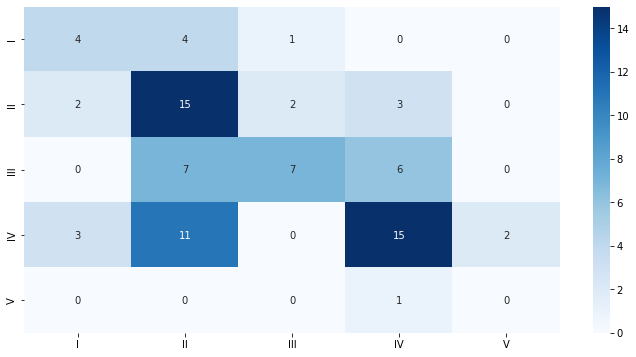

In [62]:
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label);

In [63]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.44      0.44      0.44         9
           1       0.41      0.68      0.51        22
           2       0.70      0.35      0.47        20
           3       0.60      0.48      0.54        31
           4       0.00      0.00      0.00         1

    accuracy                           0.49        83
   macro avg       0.43      0.39      0.39        83
weighted avg       0.55      0.49      0.50        83



In [82]:

# Build a LSTM Neural Network
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 200, trainable=True)(deep_inputs)

LSTM_Layer_1 = Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5))(embedding_layer)
#max_pool_layer_1 = GlobalMaxPool1D()(LSTM_Layer_1)
drop_out_layer_1 = Dropout(0.5, input_shape = (256,))(LSTM_Layer_1)
dense_layer_1 = Dense(128, activation = 'relu')(drop_out_layer_1)
drop_out_layer_2 = Dropout(0.5, input_shape = (128,))(dense_layer_1)
dense_layer_2 = Dense(64, activation = 'relu')(drop_out_layer_2)
drop_out_layer_3 = Dropout(0.5, input_shape = (64,))(dense_layer_2)

dense_layer_3 = Dense(32, activation = 'relu')(drop_out_layer_3)
drop_out_layer_4 = Dropout(0.5, input_shape = (32,))(dense_layer_3)

dense_layer_4 = Dense(10, activation = 'relu')(drop_out_layer_4)
drop_out_layer_5 = Dropout(0.5, input_shape = (10,))(dense_layer_4)

dense_layer_5 = Dense(5, activation='softmax')(drop_out_layer_5)

lstm_model = Model(inputs=deep_inputs, outputs=dense_layer_5)

opt = optimizers.Adam(lr=0.001)
#opt = optimizers.SGD(lr=0.0001, momentum=0.9)
lstm_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

In [83]:
lstm_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 200, 200)          689200    
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              336896    
 nal)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                           

In [84]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, min_delta=0.001)
# fit the keras model on the dataset X_text_train, np.array(y_aug_train)
training_history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/20
21/21 [==============================] - 36s 1s/step - loss: 1.5994 - acc: 0.2424 - val_loss: 1.5676 - val_acc: 0.3735
Epoch 2/20
21/21 [==============================] - 28s 1s/step - loss: 1.5978 - acc: 0.2881 - val_loss: 1.5646 - val_acc: 0.3012
Epoch 3/20
21/21 [==============================] - 27s 1s/step - loss: 1.5757 - acc: 0.2835 - val_loss: 1.5264 - val_acc: 0.3735
Epoch 4/20
21/21 [==============================] - 27s 1s/step - loss: 1.5733 - acc: 0.2835 - val_loss: 1.5349 - val_acc: 0.3735


In [78]:
# evaluate the keras model
_, train_accuracy = lstm_model.evaluate(X_text_train, y_text_train, batch_size=8, verbose=0)
_, test_accuracy = lstm_model.evaluate(X_text_test, y_text_test, batch_size=8, verbose=0)

print('Train accuracy: %.2f' % (train_accuracy*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

Train accuracy: 32.62
Test accuracy: 37.35


In [79]:
y_pred = lstm_model.predict(X_text_test, verbose=0) # Multiclass
y_pred_index = np.argmax(y_pred,axis=1)
y_original = np.argmax(y_text_test, axis =1)

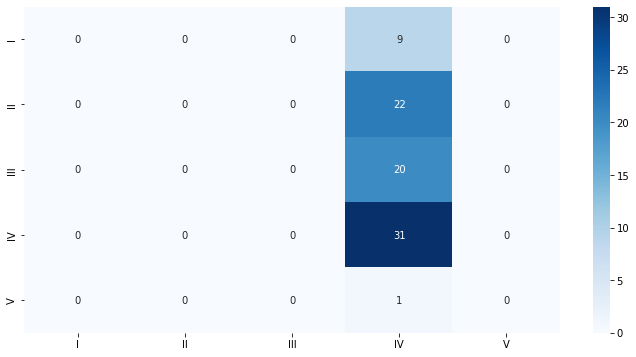

In [80]:
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label);

In [81]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        20
           3       0.37      1.00      0.54        31
           4       0.00      0.00      0.00         1

    accuracy                           0.37        83
   macro avg       0.07      0.20      0.11        83
weighted avg       0.14      0.37      0.20        83



## Transformer Models

In [85]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [128]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-4)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-4)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)



In [ ]:
    def get_config(self):
        config = super().get_config()
        config.update({
            "att": self.att,
            "ffn": self.ffn,
            "layernorm1": self.layernorm1,
            "layernorm2": self.layernorm2,
            "dropout1": self.dropout1,
            "dropout2": self.dropout2,
        })
        return config



    def get_config(self):
        config = super().get_config()
        config.update({
            "token_emb": self.token_emb,
            "pos_emb": self.pos_emb,
        })
        return config


In [129]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [130]:
embed_dim = 300  # Embedding size for each token
num_heads = 5  # Number of attention heads
ff_dim = 200 # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(200,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(5, activation="softmax")(x)


model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 300)         1093800   
 g_5 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_5 (Transf  (None, 200, 300)         1926500   
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_5   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_52 (Dropout)        (None, 300)               0  

In [131]:
epochs = 50
batch_size = 32
loss = "categorical_crossentropy"
opt = keras.optimizers.Adam(lr=1e-3)

metrics = ["acc"]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

model.compile(optimizer=opt, loss=loss, metrics=metrics)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks = [callback])

Epoch 1/50
21/21 [==============================] - 47s 2s/step - loss: 1.6501 - acc: 0.2927 - val_loss: 1.5711 - val_acc: 0.2651
Epoch 2/50
21/21 [==============================] - 45s 2s/step - loss: 1.5955 - acc: 0.3095 - val_loss: 1.5952 - val_acc: 0.3735
Epoch 3/50
21/21 [==============================] - 45s 2s/step - loss: 1.5953 - acc: 0.3262 - val_loss: 1.5868 - val_acc: 0.3735
Epoch 4/50
21/21 [==============================] - 45s 2s/step - loss: 1.5888 - acc: 0.3262 - val_loss: 1.5786 - val_acc: 0.3735


In [114]:
model.save("Transformer_aug_model.h5")

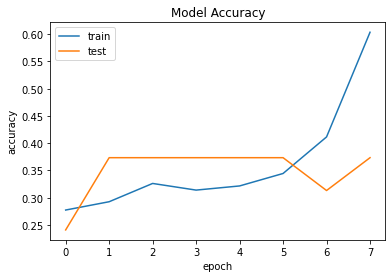

In [117]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

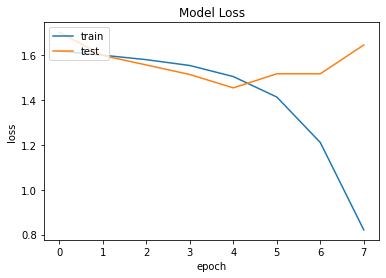

In [118]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [119]:
#predict the labels
y_predicted_labels = model.predict(X_text_test)

In [120]:
y_pred_index = np.argmax(y_predicted_labels,axis=1)
y_original = np.argmax(y_text_test, axis =1)

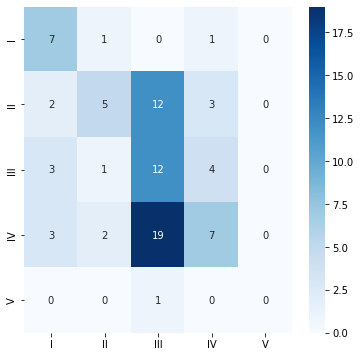

In [121]:
#plot the confusion matrix
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label,fmt='g');

In [122]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.47      0.78      0.58         9
           1       0.56      0.23      0.32        22
           2       0.27      0.60      0.37        20
           3       0.47      0.23      0.30        31
           4       0.00      0.00      0.00         1

    accuracy                           0.37        83
   macro avg       0.35      0.37      0.32        83
weighted avg       0.44      0.37      0.35        83



In [139]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

In [157]:
y_predict = base_model.predict(X_test)

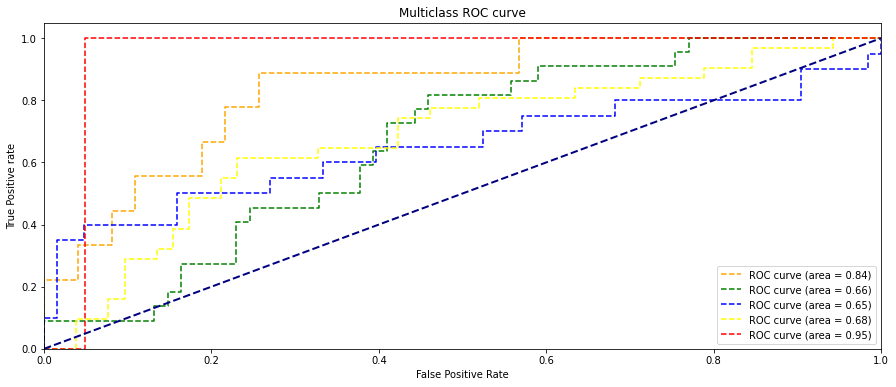

In [167]:
fpr = {}
tpr = {}
#thresh ={}
roc_auc = dict()

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i],_ = roc_curve(y_test[:,i], y_predict[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plotting  
plt.figure(figsize=(15, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label="ROC curve (area = %0.2f)" % roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label="ROC curve (area = %0.2f)" % roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label="ROC curve (area = %0.2f)" % roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label= "ROC curve (area = %0.2f)" % roc_auc[3])
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label="ROC curve (area = %0.2f)" % roc_auc[4])

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc="lower right")
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    

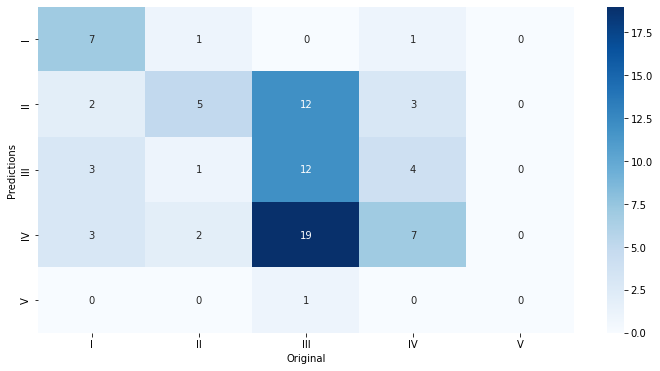

In [166]:
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label);
plt.xlabel('Original');
plt.ylabel('Predictions');

In [123]:
# save the model to disk
from keras.models import load_model
tr_model = load_model('Transformer_aug_model.h5')

ValueError: ignored